In [1]:
#Data Augmenation method 1: Increase the volume
from pydub import AudioSegment
import os

directory = '../Data/calltypes/calltype_wave/Test'

for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        sound = AudioSegment.from_wav(os.path.join(directory, filename))
        louder_sound = sound + 10  # 以分贝为单位提高音量
        louder_sound.export(os.path.join(directory, "louder_" + filename), format="wav")

print("All files have been incresed volume.")

All files have been incresed volume.


In [4]:
#Final step: to standardize the sound to 1 second
import os
import librosa
import soundfile as sf
import numpy as np

def process_directory(input_directory):
    output_directory = os.path.join(input_directory, 'processed')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file in os.listdir(input_directory):
        if file.lower().endswith('.wav'):
            file_path = os.path.join(input_directory, file)
            data, sr = librosa.load(file_path, sr=None)
            
            # Calculate the number of sample points with a target length of 2 seconds
            target_length = int(1 * sr)
            
            # If audio length is less than target length, use np.tile to copy data to pad to 1 second
            if len(data) < target_length:
                num_repeats = target_length // len(data)
                remainder = target_length % len(data)
                augmented_data = np.tile(data, num_repeats)
                augmented_data = np.concatenate((augmented_data, data[:remainder]))
            else:
                # Intercept the first seconds
                augmented_data = data[:target_length]
            
            # Path to generate output file
            output_file_path = os.path.join(output_directory, file)
            
            # Save processed audio
            sf.write(output_file_path, augmented_data, sr)
    
    print("All files have been processed and saved in the 'processed' directory.")

# Specify the directory containing the original Wave file
#D:\Work\Dalhousie\AudioClipComparison\Data\calltypes\calltype_wave\Train\S44
path_to_wav_files = '../Data/calltypes/calltype_wave/Train/S44'
#path_to_wav_files = '../Data/calltypes/calltype_wave/Test'
process_directory(path_to_wav_files)


All files have been processed and saved in the 'processed' directory.


In [ ]:
#Reduce the noise
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import noisereduce as nr

# 读取WAV文件
rate, data = wavfile.read('../Data/calltypes/train_wave/S1/louder_file (0).wav')  # 替换成你的文件名

# 可视化原始数据
plt.figure(figsize=(12, 4))
plt.plot(data)
plt.title('Original Audio Waveform')
plt.show()

# 若信号是立体声的，则取一个通道
if len(data.shape) > 1:
    data = data[:, 0]

# 使用noisereduce库降噪
# 注意：可以选择一段纯噪声的数据作为参考
reduced_noise = nr.reduce_noise(y=data, sr=rate)

# 可视化降噪后的波形
plt.figure(figsize=(12, 4))
plt.plot(reduced_noise)
plt.title('Noise Reduced Audio Waveform')
plt.show()

# 保存降噪后的WAV文件
wavfile.write('../Data/calltypes/train_wave/S1/louder_file(0)denoise.wav', rate, reduced_noise.astype(np.int16))


In [35]:
#Data Augmenation method 2: Denoise
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import noisereduce as nr
import os

input_directory = 'D:\Work\Data\Calltypes\calltype_wave\FSLTrain\Seawave'  
output_directory = os.path.join(input_directory, 'denoised')  

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for filename in os.listdir(input_directory):
    if filename.endswith(".wav"):
        
        filepath = os.path.join(input_directory, filename)
        rate, data = wavfile.read(filepath)
        if len(data.shape) > 1:
            data = data[:, 0]

        reduced_noise = nr.reduce_noise(y=data, sr=rate)

        output_filepath = os.path.join(output_directory, f'denoised_{filename}')
        wavfile.write(output_filepath, rate, reduced_noise.astype(np.int16))
        

print("All files have been processed.")


All files have been processed.


In [37]:
#Data Augmenation method 3: pitch_shifting, random_shift, volume_scaling, time_stretching

import os
import numpy as np
import librosa
import soundfile as sf

def pitch_shifting(data):
    sr  = 16000
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'),  sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return data

def random_shift(data):
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    start = int(data.shape[0] * timeshift_fac)
    if (start > 0):
        data = np.pad(data,(start,0),mode='constant')[0:data.shape[0]]
    else:
        data = np.pad(data,(0,-start),mode='constant')[0:data.shape[0]]
    return data

def volume_scaling(data):
    sr  = 16000
    dyn_change = np.random.uniform(low=1.5,high=2.5)
    data = data * dyn_change
    return data
    
def time_stretching(data, rate=1.5):
    input_length = len(data)
    streching = data.copy()
    streching = librosa.effects.time_stretch(streching, rate)
    
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(data, (0, max(0, input_length - len(streching))), "constant")
    return streching

def audio_augmentation(directory, file, data):
    aug_file_path = os.path.join(directory, file)
    sf.write(aug_file_path, data, 16000, 'PCM_24')

def process_directory(input_directory):
    output_directory = os.path.join(input_directory, 'augmented')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file in os.listdir(input_directory):
        if file.lower().endswith('.wav'):
            file_path = os.path.join(input_directory, file)
            data, sr = librosa.load(file_path, sr=16000)
            
            pitch_shifted_data = pitch_shifting(data)
            random_shift_data = random_shift(data)
            volume_scaled_data = volume_scaling(data)
            time_stretched_data = time_stretching(data)
            
            augmented_data = [pitch_shifted_data, time_stretched_data, random_shift_data, volume_scaled_data]
            
            for i, aug_data in enumerate(augmented_data):
                augmented_file_name = f"{os.path.splitext(file)[0]}_augmented_{i}.wav"
                audio_augmentation(output_directory, augmented_file_name, aug_data)
    
    print("All files have been processed and augmented.")

path_to_wav_files = 'D:\Work\Data\Calltypes\calltype_wave\FSLTestNew\DelawSpwale'
process_directory(path_to_wav_files)


C:\Users\jiezh\AppData\Local\Temp\ipykernel_31184\1795180629.py:13: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.effects.pitch_shift(data.astype('float64'),  sr, n_steps=pitch_change,
C:\Users\jiezh\AppData\Local\Temp\ipykernel_31184\1795180629.py:35: FutureWarning: Pass rate=1.5 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  streching = librosa.effects.time_stretch(streching, rate)


All files have been processed and augmented.


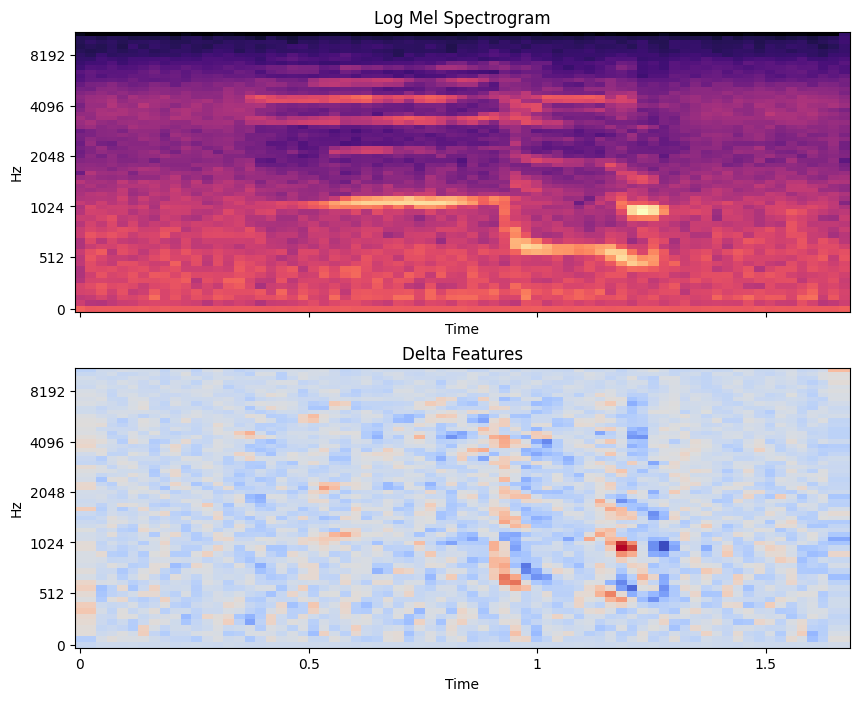

In [39]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 加载音频文件
#y, sr = librosa.load(librosa.ex('trumpet')) #D:\Work\Data\Calltypes\calltype_wave\FSLTrain\Seawave
y, sr = librosa.load('D:\Work\Data\Calltypes\calltype_wave\FSLTrain\S1d\FO-S01.wav') #D:\Work\Data\Calltypes\calltype_wave\FSLTrain\Seawave


# 计算对数梅尔频谱图
n_fft = 1024
hop_length = 512
mel_bins = 60
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=mel_bins)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# 计算Delta特征
delta_features = librosa.feature.delta(log_mel_spectrogram, width=3)

# 显示对数梅尔频谱图和Delta特征
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Log Mel Spectrogram')
librosa.display.specshow(delta_features, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Delta Features')
plt.show()


#siamese result.csv processed
import pandas as pd

# 读取CSV文件
df = pd.read_csv('../Data/calltypes/ketos_images/calltypetrn_data.csv')

# 根据Euclidean Distance的值添加'pred'列
df['pred'] = df['Euclidean Distance'].apply(lambda x: 0 if x < 0.05 else 1)

# 将DataFrame保存到新的CSV文件中
df.to_csv('../Data/calltypes/ketos_images/calltypetrn_pred1108.csv', index=False)
